## Import Module/Library

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

from retinaface import RetinaFace

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


## Config Parameters

In [ ]:
BATCH_SIZE = 32
IMG_HEGIHT  = 224
IMG_WIDHT   = 224
IMG_CHANNEL = 3
BUFFER_SIZE = BATCH_SIZE*10

IMG_PATH = "/media/aivn24/partition2/Khoa/AI2021/Domain_Conversion/code/makeup_data"

##  Load Data

In [ ]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=IMG_CHANNEL)
    
    # Split each image tensor into two tensors:
    # - non-makeup image
    # - makeup image
    w = tf.shape(image)[1]
    w = w // 3
    input_image  = image[:, w*2:w*3, :]
    target_image = image[:, w:w*2, :]

    input_image  = tf.image.resize(input_image, (IMG_HEGIHT, IMG_WIDHT))
    target_image = tf.image.resize(target_image, (IMG_HEGIHT, IMG_WIDHT))
    
    # Convert both images to float32 tensors
    input_image  = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    
    return input_image, target_image

(224, 224, 3)
(224, 224, 3)


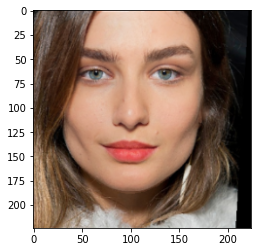

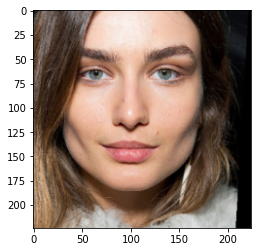

In [ ]:

input_image, target_image = load(str(IMG_PATH + '/train/0.png'))
print(input_image.shape)
print(target_image.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(input_image/255.0)
plt.figure()
plt.imshow(target_image/255.0)


In [ ]:
@tf.function()
def random_flip(input_image, target_image):
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)

    return input_image, target_image


def processing_image(input_image, target_image):
    input_image = tf.keras.applications.resnet50.preprocess_input(input_image)
    target_image = (target_image / 255.0)
    return input_image, target_image


def load_image_train(image_file):
    input_image, target_image = load(image_file)
    input_image, target_image = random_flip(input_image, target_image)
    input_image, target_image = processing_image(input_image, target_image)

    return input_image, target_image


def load_image_val(image_file):
    input_image, target_image = load(image_file)
    input_image, target_image = processing_image(input_image, target_image)

    return input_image, target_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/train/*.png'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


In [ ]:
val_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/val/*.png'))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/test/*.png'))
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build Model 

In [ ]:
class BuildRes50Unet():
    def __init__(self):
        
        self.encoder_blocks_name = ["conv1_relu", "conv2_block3_out", "conv3_block4_out",
                                    "conv4_block6_out"]
        self.bridge_block_name = "conv5_block3_out"
#         self.encoder_blocks_name = ["input_1", "conv1_relu", "conv2_block3_out", "conv3_block4_out"]
#         self.bridge_block_name = "conv4_block6_out"
    
    def conv_block(self, inputs, num_filters):
        x = layers.Conv2D(filters=num_filters, kernel_size=(3,3), padding="same")(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        
        x = layers.Conv2D(filters=num_filters, kernel_size=(3,3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        
        return x
    
    
    def upsample_concate_block(self, inputs, skip_connection, num_filters):
        x = layers.Conv2DTranspose(filters=num_filters, kernel_size=(2,2), strides=2, padding='same')(inputs)
        x = layers.Concatenate()([skip_connection, x])
        x = self.conv_block(x, num_filters)
        
        return x
    
    
    def build_model(self, input_shape):
        inputs = layers.Input(shape=input_shape)
        
        # encoder
        backbone = tf.keras.applications.ResNet50(include_top=False, input_tensor=inputs,
                                                  weights='imagenet')
        eb0 = backbone.get_layer(name=self.encoder_blocks_name[0]).output
        eb1 = backbone.get_layer(name=self.encoder_blocks_name[1]).output
        eb2 = backbone.get_layer(name=self.encoder_blocks_name[2]).output
        eb3 = backbone.get_layer(name=self.encoder_blocks_name[3]).output
        
        # bridge
        br = backbone.get_layer(name=self.bridge_block_name).output
        
        # decoder
        db3 = self.upsample_concate_block(inputs=br, skip_connection=eb3, num_filters=512)
        db2 = self.upsample_concate_block(inputs=db3, skip_connection=eb2, num_filters=256)
        db1 = self.upsample_concate_block(inputs=db2, skip_connection=eb1, num_filters=128)
        db0 = self.upsample_concate_block(inputs=db1, skip_connection=eb0, num_filters=64)
        
        # final output
        first_feature = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(inputs)
        final_feature = self.upsample_concate_block(inputs=db0, skip_connection=first_feature, num_filters=64)
        outputs = layers.Conv2D(filters=3, kernel_size=(1,1), activation='sigmoid')(final_feature)
        
        model = Model(inputs=inputs, outputs=outputs)
        
        return  model

In [ ]:
model = BuildRes50Unet()
res50Unet = model.build_model(input_shape=(IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL))

In [ ]:
# res50Unet.summary()

## Config and Compile Model

### Show Generated Images and Evaluation Function

In [ ]:
def evaluate(model, epoch, dataset):  
    psnr_mean = 0.0
    count = 0
    for inputs, targets in dataset:
        fake = model([inputs], training=True)
        
        psnr = tf.image.psnr(fake, targets, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        # psnr_mean = psnr_mean_l
        
        psnr_mean += __psnr_mean
        count =count + 1
    
    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)
    
    return psnr_mean
    

def generate_images(model, inputs, targets):
    fake = model([inputs], training=True)
    plt.figure(figsize=(15,20))
    mean = np.array([103.939, 116.779, 123.68])
    mean = mean.reshape((1,1,3))
    a = inputs[0] + mean
    
    a = a[..., ::-1]
#     x = x[..., ::-1]
    
    display_list = [a/255, targets[0], fake[0]]
    
    
    title = ['Input', 'Real', 'Predicted']    

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()       

### Loss

In [ ]:
class PeceptualLoss():
    def __init__(self, input_shape):
        self.layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4']
        self.extractor = self.get_extractor(input_shape)
        self.MSE = tf.keras.losses.MeanSquaredError()
        self.vgg_preprocessing = tf.keras.applications.vgg19.preprocess_input
    
    
    def get_extractor(self, input_shape):
        vgg = tf.keras.applications.VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in self.layer_names]
        model = Model(inputs=vgg.input, outputs=outputs)
        
        return model
        
        
    def percep_loss(self, target_image, fake_image):
        target_image *= 255.0
        fake_image *= 255.0
        
        target_image = self.vgg_preprocessing(target_image)
        fake_image = self.vgg_preprocessing(fake_image)
        
        target_features = self.extractor(target_image)
        fake_features = self.extractor(fake_image)
        
        loss = tf.add_n([tf.reduce_mean((tar_fea-fk_fea)**2) 
                         for  tar_fea, fk_fea in zip(target_features, fake_features)])
        loss = loss/len(fake_features)
        return loss

In [ ]:
per_loss = PeceptualLoss(input_shape=(IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL))

In [ ]:
def generator_loss(fake, target, loss_type='L1'):
    loss_list = ["L1", "Percep"]
    assert loss_type in loss_list
    # L1
    if loss_type == loss_list[0]:
        loss = tf.reduce_mean(tf.abs(fake-target))*100
    # Perceptual Loss
    elif loss_type == loss_list[1]:
        loss = per_loss.percep_loss(target, fake)
    return loss

### Optimizer

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

## Training

In [ ]:
LOSS_TYPE = 'Percep'

In [ ]:

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        # output
        fake = res50Unet([inputs], training=True)     
        loss = generator_loss(fake, targets, loss_type=LOSS_TYPE)

    generator_gradients = tape.gradient(loss, res50Unet.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, res50Unet.trainable_variables))
    
    return loss

    
    
def fit(train_ds, epochs, val_ds):
    best_pnsr = 0.0
    step_counter = 0
    for epoch in range(epochs):
        # Train
        total_loss = 0.0
        for inputs, targets in train_ds:
            loss = train_step(inputs, targets)
            total_loss = total_loss + loss
            step_counter += 1
        total_loss = total_loss/step_counter
        print('epoch: {}   loss: {}'.format(epoch, total_loss))
        
        pnsr = evaluate(res50Unet, epoch, val_ds)        
        if best_pnsr < pnsr:
            best_pnsr = pnsr
            
            for inputs, targets in val_ds.take(1):
                generate_images(res50Unet, inputs, targets)


epoch: 0   loss: 51909.1875
-------- psnr:  18.550972    ----- epoch:  0   count:  4


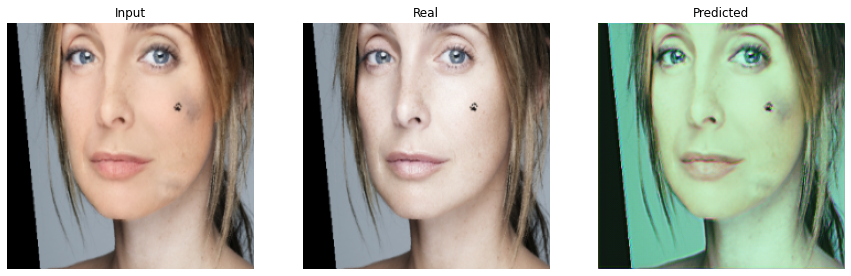

epoch: 1   loss: 11960.6650390625
-------- psnr:  19.494339    ----- epoch:  1   count:  4


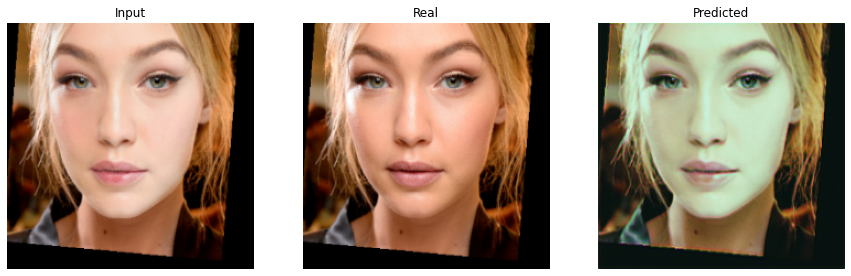

epoch: 2   loss: 6022.17724609375
-------- psnr:  20.31402    ----- epoch:  2   count:  4


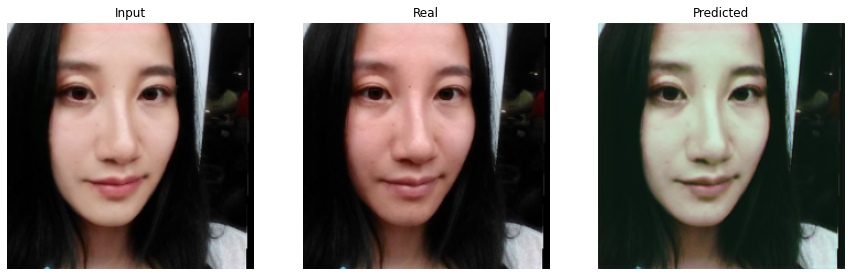

epoch: 3   loss: 3642.21923828125
-------- psnr:  21.238787    ----- epoch:  3   count:  4


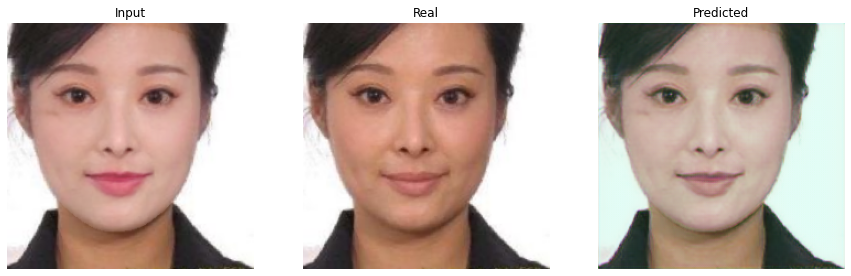

epoch: 4   loss: 2414.251220703125
-------- psnr:  22.240326    ----- epoch:  4   count:  4


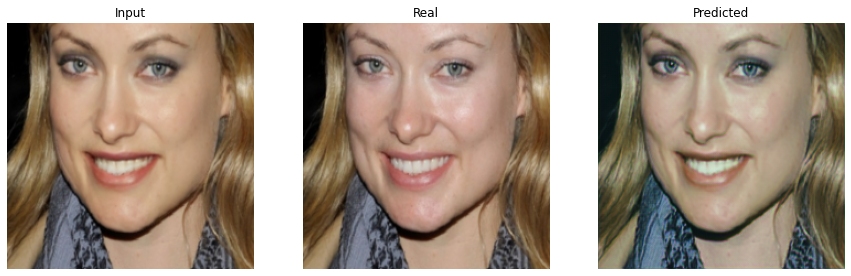

epoch: 5   loss: 1711.3431396484375
-------- psnr:  21.621939    ----- epoch:  5   count:  4
epoch: 6   loss: 1306.7310791015625
-------- psnr:  23.010906    ----- epoch:  6   count:  4


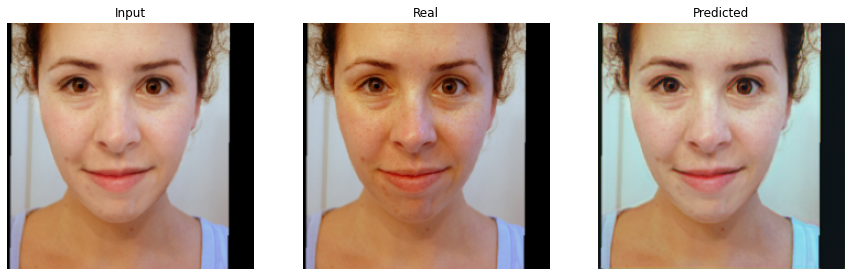

epoch: 7   loss: 1056.2896728515625
-------- psnr:  23.73649    ----- epoch:  7   count:  4


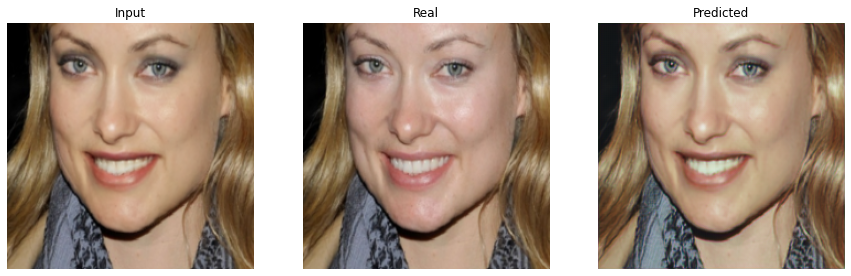

epoch: 8   loss: 853.1215209960938
-------- psnr:  23.502144    ----- epoch:  8   count:  4
epoch: 9   loss: 720.1971435546875
-------- psnr:  24.425133    ----- epoch:  9   count:  4


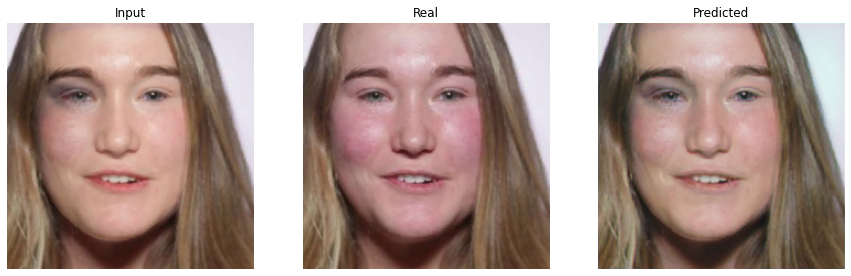

epoch: 10   loss: 601.3876342773438
-------- psnr:  24.582354    ----- epoch:  10   count:  4


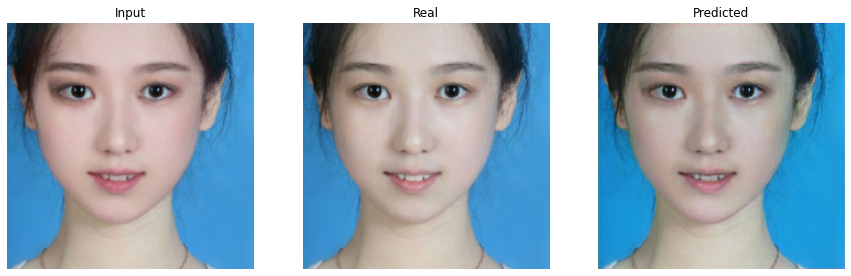

epoch: 11   loss: 509.048583984375
-------- psnr:  24.305439    ----- epoch:  11   count:  4
epoch: 12   loss: 439.3565979003906
-------- psnr:  25.506586    ----- epoch:  12   count:  4


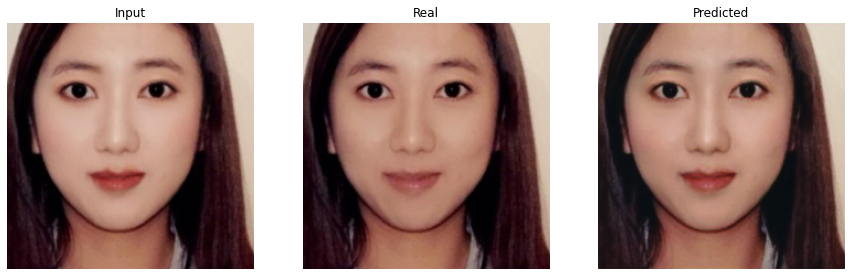

epoch: 13   loss: 382.8421325683594
-------- psnr:  24.416145    ----- epoch:  13   count:  4
epoch: 14   loss: 347.0825500488281
-------- psnr:  25.264938    ----- epoch:  14   count:  4
epoch: 15   loss: 308.1232604980469
-------- psnr:  24.786022    ----- epoch:  15   count:  4
epoch: 16   loss: 283.5906066894531
-------- psnr:  25.389666    ----- epoch:  16   count:  4
epoch: 17   loss: 252.853271484375
-------- psnr:  25.219215    ----- epoch:  17   count:  4
epoch: 18   loss: 227.2279052734375
-------- psnr:  25.22476    ----- epoch:  18   count:  4
epoch: 19   loss: 211.6074676513672
-------- psnr:  25.392326    ----- epoch:  19   count:  4
epoch: 20   loss: 191.16343688964844
-------- psnr:  25.543205    ----- epoch:  20   count:  4


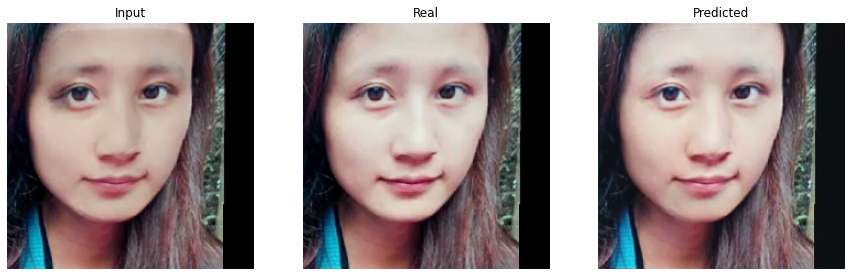

epoch: 21   loss: 175.32000732421875
-------- psnr:  25.105326    ----- epoch:  21   count:  4
epoch: 22   loss: 161.70028686523438
-------- psnr:  24.575466    ----- epoch:  22   count:  4
epoch: 23   loss: 146.02044677734375
-------- psnr:  25.934343    ----- epoch:  23   count:  4


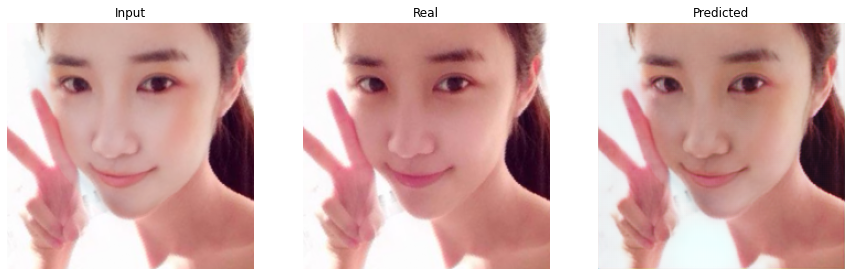

epoch: 24   loss: 140.56016540527344
-------- psnr:  26.247257    ----- epoch:  24   count:  4


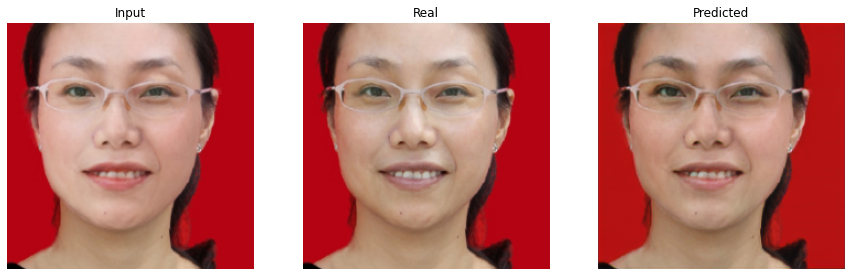

epoch: 25   loss: 131.1991729736328
-------- psnr:  23.965477    ----- epoch:  25   count:  4
epoch: 26   loss: 130.3546905517578
-------- psnr:  25.78213    ----- epoch:  26   count:  4
epoch: 27   loss: 121.8456802368164
-------- psnr:  25.53751    ----- epoch:  27   count:  4
epoch: 28   loss: 108.76964569091797
-------- psnr:  26.117165    ----- epoch:  28   count:  4
epoch: 29   loss: 103.2362289428711
-------- psnr:  24.530527    ----- epoch:  29   count:  4
epoch: 30   loss: 98.41462707519531
-------- psnr:  25.952744    ----- epoch:  30   count:  4
epoch: 31   loss: 89.92195129394531
-------- psnr:  26.883266    ----- epoch:  31   count:  4


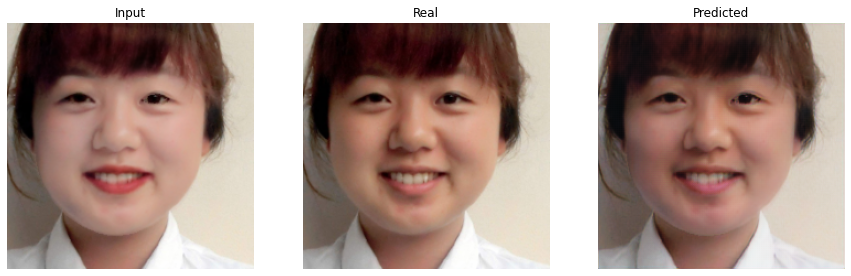

epoch: 32   loss: 88.42025756835938
-------- psnr:  25.139866    ----- epoch:  32   count:  4
epoch: 33   loss: 83.41191864013672
-------- psnr:  25.966066    ----- epoch:  33   count:  4
epoch: 34   loss: 77.73748016357422
-------- psnr:  25.52246    ----- epoch:  34   count:  4
epoch: 35   loss: 77.10686492919922
-------- psnr:  25.96382    ----- epoch:  35   count:  4
epoch: 36   loss: 70.93134307861328
-------- psnr:  25.10534    ----- epoch:  36   count:  4
epoch: 37   loss: 69.76994323730469
-------- psnr:  26.4465    ----- epoch:  37   count:  4
epoch: 38   loss: 64.62664031982422
-------- psnr:  25.95951    ----- epoch:  38   count:  4
epoch: 39   loss: 63.1796989440918
-------- psnr:  25.8866    ----- epoch:  39   count:  4
epoch: 40   loss: 58.630001068115234
-------- psnr:  26.217426    ----- epoch:  40   count:  4
epoch: 41   loss: 56.51521682739258
-------- psnr:  24.945251    ----- epoch:  41   count:  4
epoch: 42   loss: 55.360965728759766
-------- psnr:  25.771841    --

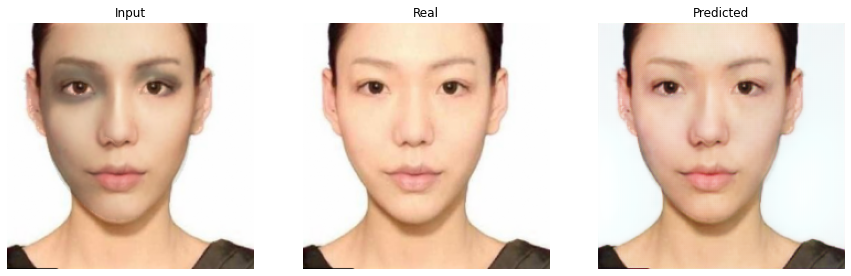

epoch: 51   loss: 39.455711364746094
-------- psnr:  25.228626    ----- epoch:  51   count:  4
epoch: 52   loss: 39.096153259277344
-------- psnr:  26.914078    ----- epoch:  52   count:  4
epoch: 53   loss: 37.9195442199707
-------- psnr:  25.623549    ----- epoch:  53   count:  4
epoch: 54   loss: 36.982601165771484
-------- psnr:  26.112232    ----- epoch:  54   count:  4
epoch: 55   loss: 35.33271026611328
-------- psnr:  26.995165    ----- epoch:  55   count:  4
epoch: 56   loss: 32.79170608520508
-------- psnr:  25.2527    ----- epoch:  56   count:  4
epoch: 57   loss: 33.021236419677734
-------- psnr:  26.21046    ----- epoch:  57   count:  4
epoch: 58   loss: 30.983108520507812
-------- psnr:  26.24953    ----- epoch:  58   count:  4
epoch: 59   loss: 32.13884353637695
-------- psnr:  26.271269    ----- epoch:  59   count:  4
epoch: 60   loss: 30.646228790283203
-------- psnr:  26.553032    ----- epoch:  60   count:  4
epoch: 61   loss: 30.096097946166992
-------- psnr:  27.203

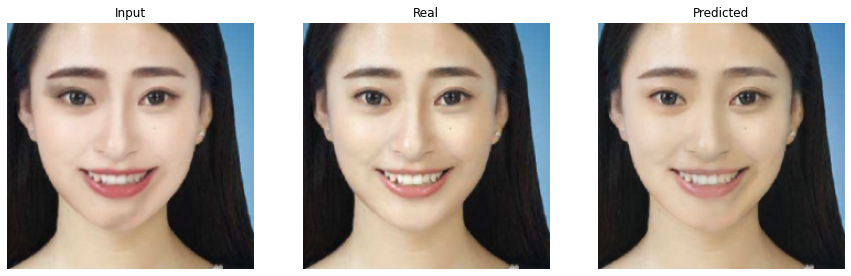

epoch: 62   loss: 29.28413200378418
-------- psnr:  26.44755    ----- epoch:  62   count:  4
epoch: 63   loss: 28.698795318603516
-------- psnr:  26.708836    ----- epoch:  63   count:  4
epoch: 64   loss: 27.4388370513916
-------- psnr:  26.450333    ----- epoch:  64   count:  4
epoch: 65   loss: 26.862491607666016
-------- psnr:  26.61344    ----- epoch:  65   count:  4
epoch: 66   loss: 26.592266082763672
-------- psnr:  26.633108    ----- epoch:  66   count:  4
epoch: 67   loss: 25.994869232177734
-------- psnr:  26.61409    ----- epoch:  67   count:  4
epoch: 68   loss: 25.807727813720703
-------- psnr:  25.10579    ----- epoch:  68   count:  4
epoch: 69   loss: 23.68743896484375
-------- psnr:  26.390787    ----- epoch:  69   count:  4
epoch: 70   loss: 24.140127182006836
-------- psnr:  26.776093    ----- epoch:  70   count:  4
epoch: 71   loss: 24.13553237915039
-------- psnr:  27.339676    ----- epoch:  71   count:  4


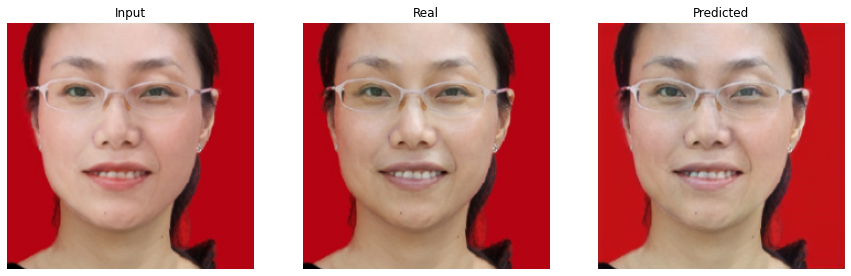

epoch: 72   loss: 22.555084228515625
-------- psnr:  27.483208    ----- epoch:  72   count:  4


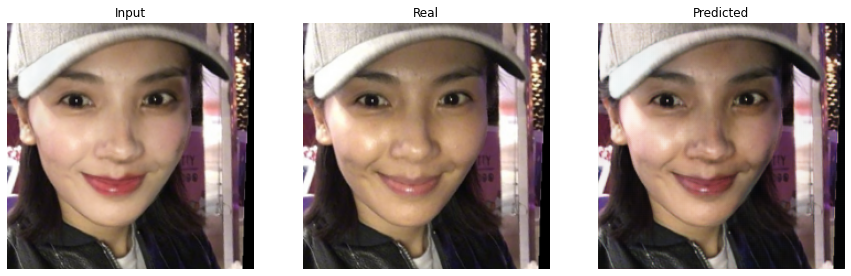

epoch: 73   loss: 34.86846923828125
-------- psnr:  26.442379    ----- epoch:  73   count:  4
epoch: 74   loss: 28.04133415222168
-------- psnr:  27.08649    ----- epoch:  74   count:  4
epoch: 75   loss: 25.214702606201172
-------- psnr:  25.357256    ----- epoch:  75   count:  4
epoch: 76   loss: 23.078243255615234
-------- psnr:  25.78435    ----- epoch:  76   count:  4
epoch: 77   loss: 23.986690521240234
-------- psnr:  25.955347    ----- epoch:  77   count:  4
epoch: 78   loss: 22.015644073486328
-------- psnr:  27.519875    ----- epoch:  78   count:  4


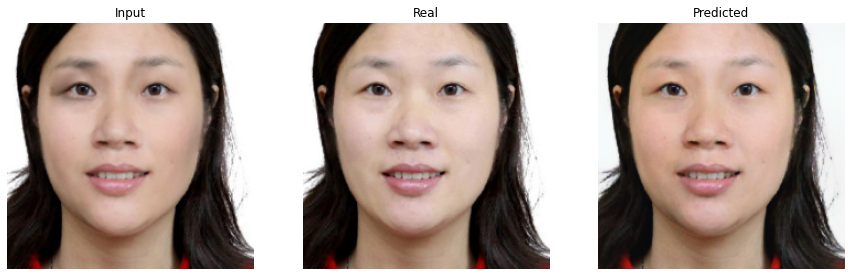

epoch: 79   loss: 20.81131935119629
-------- psnr:  25.491974    ----- epoch:  79   count:  4
epoch: 80   loss: 19.960784912109375
-------- psnr:  26.355898    ----- epoch:  80   count:  4
epoch: 81   loss: 19.607555389404297
-------- psnr:  27.413887    ----- epoch:  81   count:  4
epoch: 82   loss: 19.17452621459961
-------- psnr:  26.579775    ----- epoch:  82   count:  4
epoch: 83   loss: 18.513809204101562
-------- psnr:  26.873005    ----- epoch:  83   count:  4
epoch: 84   loss: 17.385976791381836
-------- psnr:  27.014412    ----- epoch:  84   count:  4
epoch: 85   loss: 18.172298431396484
-------- psnr:  26.068481    ----- epoch:  85   count:  4
epoch: 86   loss: 17.70217514038086
-------- psnr:  26.701101    ----- epoch:  86   count:  4
epoch: 87   loss: 16.776470184326172
-------- psnr:  25.508842    ----- epoch:  87   count:  4
epoch: 88   loss: 16.35306167602539
-------- psnr:  26.29227    ----- epoch:  88   count:  4
epoch: 89   loss: 16.075733184814453
-------- psnr:  27

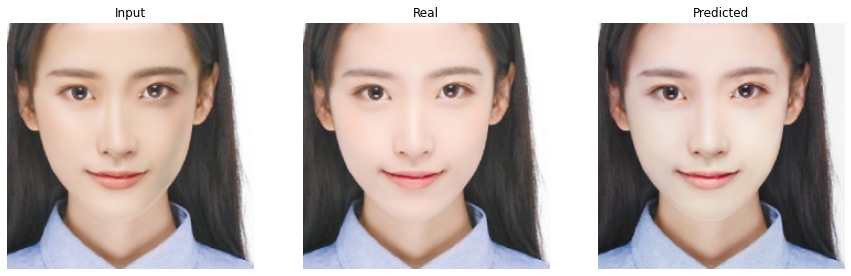

epoch: 96   loss: 15.685775756835938
-------- psnr:  25.571758    ----- epoch:  96   count:  4
epoch: 97   loss: 15.264119148254395
-------- psnr:  26.95906    ----- epoch:  97   count:  4
epoch: 98   loss: 13.658793449401855
-------- psnr:  27.448313    ----- epoch:  98   count:  4
epoch: 99   loss: 13.562056541442871
-------- psnr:  27.002584    ----- epoch:  99   count:  4
epoch: 100   loss: 13.165120124816895
-------- psnr:  26.922642    ----- epoch:  100   count:  4
epoch: 101   loss: 13.2254056930542
-------- psnr:  25.889755    ----- epoch:  101   count:  4
epoch: 102   loss: 12.4595365524292
-------- psnr:  26.874878    ----- epoch:  102   count:  4
epoch: 103   loss: 12.458924293518066
-------- psnr:  27.979956    ----- epoch:  103   count:  4


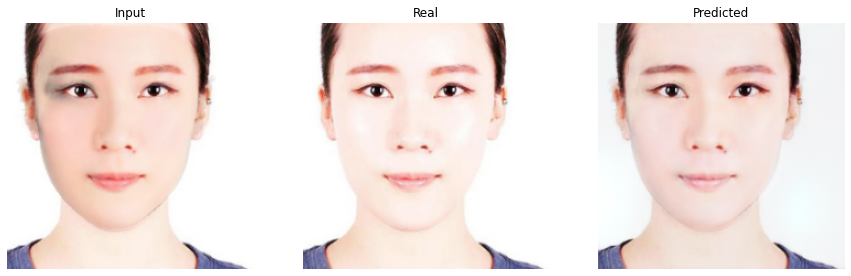

epoch: 104   loss: 12.164509773254395
-------- psnr:  27.168886    ----- epoch:  104   count:  4
epoch: 105   loss: 11.796808242797852
-------- psnr:  26.620382    ----- epoch:  105   count:  4
epoch: 106   loss: 12.594378471374512
-------- psnr:  26.05341    ----- epoch:  106   count:  4
epoch: 107   loss: 11.73459529876709
-------- psnr:  25.881065    ----- epoch:  107   count:  4
epoch: 108   loss: 11.695667266845703
-------- psnr:  27.02291    ----- epoch:  108   count:  4
epoch: 109   loss: 12.598637580871582
-------- psnr:  27.48985    ----- epoch:  109   count:  4
epoch: 110   loss: 11.14339828491211
-------- psnr:  26.436647    ----- epoch:  110   count:  4
epoch: 111   loss: 11.176983833312988
-------- psnr:  26.263283    ----- epoch:  111   count:  4
epoch: 112   loss: 10.96029281616211
-------- psnr:  26.183294    ----- epoch:  112   count:  4
epoch: 113   loss: 10.55294418334961
-------- psnr:  26.82539    ----- epoch:  113   count:  4
epoch: 114   loss: 11.059245109558105


epoch: 190   loss: 4.703629016876221
-------- psnr:  26.865505    ----- epoch:  190   count:  4
epoch: 191   loss: 4.587836265563965
-------- psnr:  25.700314    ----- epoch:  191   count:  4
epoch: 192   loss: 4.724109649658203
-------- psnr:  27.034832    ----- epoch:  192   count:  4
epoch: 193   loss: 4.451479911804199
-------- psnr:  26.534927    ----- epoch:  193   count:  4
epoch: 194   loss: 4.852021217346191
-------- psnr:  26.959139    ----- epoch:  194   count:  4
epoch: 195   loss: 4.780633926391602
-------- psnr:  25.784336    ----- epoch:  195   count:  4
epoch: 196   loss: 4.971083164215088
-------- psnr:  26.539736    ----- epoch:  196   count:  4
epoch: 197   loss: 4.497372150421143
-------- psnr:  25.871098    ----- epoch:  197   count:  4
epoch: 198   loss: 4.730654716491699
-------- psnr:  26.052166    ----- epoch:  198   count:  4
epoch: 199   loss: 4.718376636505127
-------- psnr:  27.41072    ----- epoch:  199   count:  4
epoch: 200   loss: 4.647421360015869
----

-------- psnr:  27.00135    ----- epoch:  275   count:  4
epoch: 276   loss: 2.500901460647583
-------- psnr:  26.497728    ----- epoch:  276   count:  4
epoch: 277   loss: 2.5607125759124756
-------- psnr:  25.342382    ----- epoch:  277   count:  4
epoch: 278   loss: 2.5366079807281494
-------- psnr:  26.592133    ----- epoch:  278   count:  4
epoch: 279   loss: 2.5708045959472656
-------- psnr:  27.137875    ----- epoch:  279   count:  4
epoch: 280   loss: 2.4954912662506104
-------- psnr:  27.28124    ----- epoch:  280   count:  4
epoch: 281   loss: 2.4656271934509277
-------- psnr:  25.350132    ----- epoch:  281   count:  4
epoch: 282   loss: 2.480354070663452
-------- psnr:  27.24465    ----- epoch:  282   count:  4
epoch: 283   loss: 2.807206392288208
-------- psnr:  26.865362    ----- epoch:  283   count:  4
epoch: 284   loss: 2.6886820793151855
-------- psnr:  25.502506    ----- epoch:  284   count:  4
epoch: 285   loss: 2.5484707355499268
-------- psnr:  28.153347    ----- e

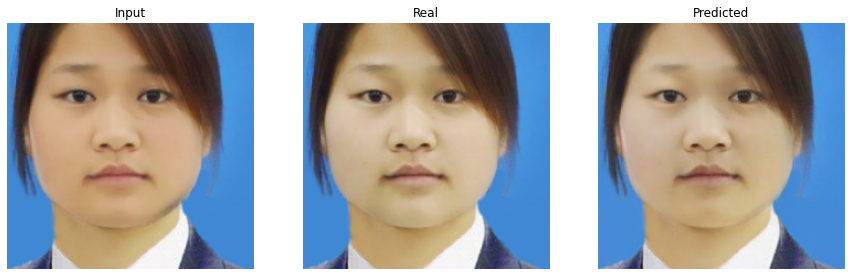

epoch: 286   loss: 2.4309351444244385
-------- psnr:  26.683178    ----- epoch:  286   count:  4
epoch: 287   loss: 2.6213183403015137
-------- psnr:  26.842001    ----- epoch:  287   count:  4
epoch: 288   loss: 2.7424700260162354
-------- psnr:  25.242981    ----- epoch:  288   count:  4
epoch: 289   loss: 2.5365264415740967
-------- psnr:  25.806034    ----- epoch:  289   count:  4
epoch: 290   loss: 2.615590810775757
-------- psnr:  25.954191    ----- epoch:  290   count:  4
epoch: 291   loss: 2.505946636199951
-------- psnr:  27.324863    ----- epoch:  291   count:  4
epoch: 292   loss: 2.541182518005371
-------- psnr:  27.013157    ----- epoch:  292   count:  4
epoch: 293   loss: 2.3665404319763184
-------- psnr:  27.472902    ----- epoch:  293   count:  4
epoch: 294   loss: 2.590207815170288
-------- psnr:  26.983746    ----- epoch:  294   count:  4
epoch: 295   loss: 2.3165862560272217
-------- psnr:  26.720818    ----- epoch:  295   count:  4
epoch: 296   loss: 2.2210750579833

In [ ]:
EPOCHS = 300
fit(train_dataset, EPOCHS, val_dataset)

## Evaluate Results

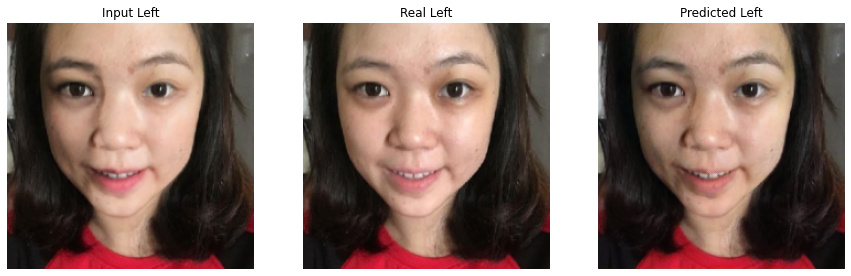

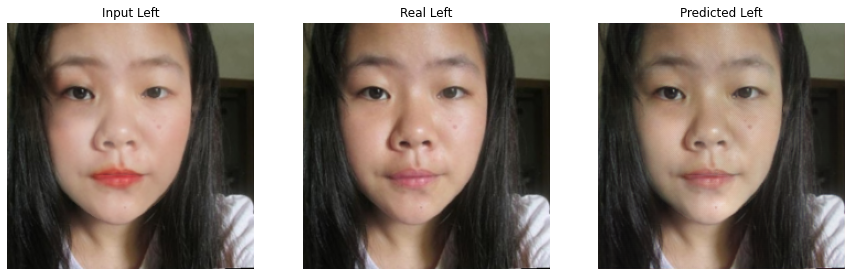

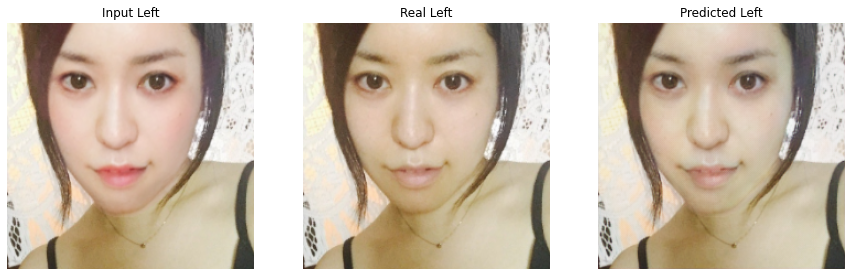

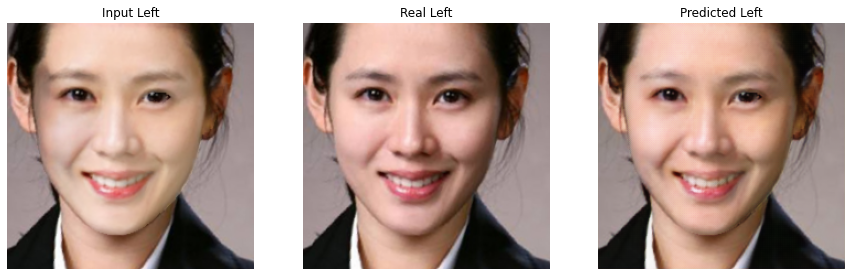

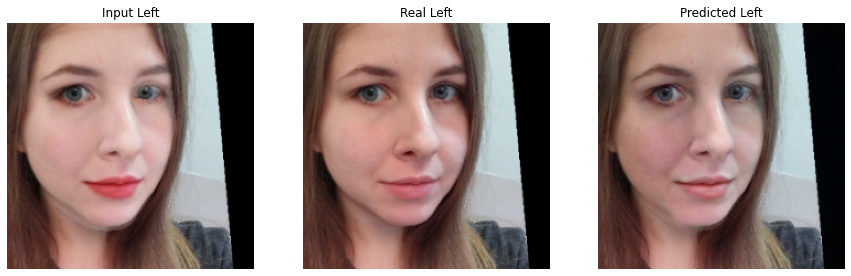

In [ ]:
for _ in range(5):
    for inputs, targets in test_dataset.take(1):
        fake = res50Unet([inputs], training=True)
        plt.figure(figsize=(15,20))
        mean = np.array([103.939, 116.779, 123.68])
        mean = mean.reshape((1,1,3))
        a = inputs[0] + mean
        a = a[..., ::-1]
        
        display_list = [a/255, targets[0], fake[0]]
        title = ['Input', 'Real', 'Predicted']    

        
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show() 